<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MOp-CGE-VipNdnf"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/MOp/CGE-VipNdnf/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

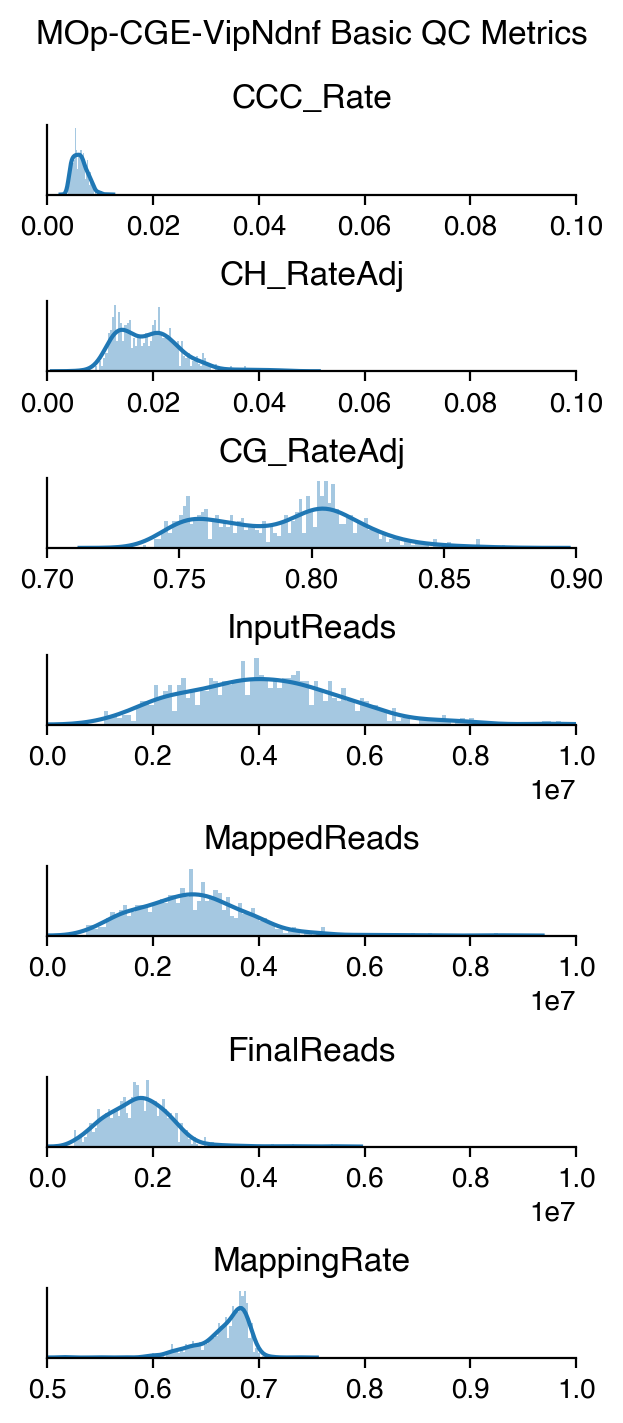

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

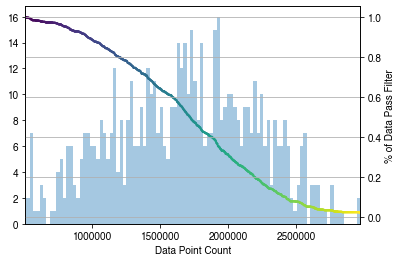

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 625/625 (100.0%)
CG_RateAdj passed 625/625 (100.0%)
CH_RateAdj passed 625/625 (100.0%)
FinalReads passed 625/625 (100.0%)
MappingRate passed 625/625 (100.0%)
Overall passed 625/625 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 40
171207 81
171212 10
171213 85
180104 67
180409 117
180410 110
180605 54
180612 61


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 83 21.6%
ad002 79 20.6%
ad004 70 18.2%
ad006 65 16.9%
ad007 83 21.6%
ad008 74 19.3%
ad010 83 21.6%
ad012 88 22.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter,consensus_cluster_rescued_anno
index,,,,,,,,,,,,,,,,,,,,,
2C_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00499,0.77449,0.77336,0.01992,0.01500,2052755.0,4610422,3198524.0,2C,...,F8,CEMBA180409-2C-4,7,5,15,10,180409,2,True,CGE-VipNdnf
2C_M_1008,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00742,0.81436,0.81297,0.03674,0.02954,2112201.0,4764230,3299438.0,2C,...,F9,CEMBA180409-2C-4,8,5,16,11,180409,2,True,CGE-VipNdnf
2C_M_1036,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00439,0.76911,0.76809,0.01527,0.01093,2337652.0,5598524,3840727.0,2C,...,G2,CEMBA180409-2C-3,1,6,2,13,180409,2,True,CGE-VipNdnf
2C_M_1045,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00425,0.74897,0.74790,0.01526,0.01106,1714560.0,3783384,2605811.0,2C,...,G3,CEMBA180409-2C-4,2,6,4,12,180409,2,True,CGE-VipNdnf
2C_M_1059,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00642,0.81547,0.81428,0.03021,0.02394,2290971.0,5430160,3723040.0,2C,...,G5,CEMBA180409-2C-4,4,6,8,13,180409,2,True,CGE-VipNdnf
2C_M_1064,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00525,0.78837,0.78725,0.02371,0.01856,1267863.0,2668820,1840917.0,2C,...,G6,CEMBA180409-2C-4,5,6,10,12,180409,2,True,CGE-VipNdnf
2C_M_1066,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00501,0.75741,0.75619,0.01892,0.01398,1213248.0,2555790,1761283.0,2C,...,G6,CEMBA180409-2C-4,5,6,11,13,180409,2,True,CGE-VipNdnf
2C_M_1098,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00430,0.74838,0.74729,0.01511,0.01086,1804220.0,3971732,2687447.0,2C,...,H11,CEMBA180409-2C-4,10,7,20,14,180409,2,True,CGE-VipNdnf
2C_M_1105,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00582,0.81029,0.80918,0.02716,0.02146,2010184.0,4330086,2959820.0,2C,...,H1,CEMBA180409-2C-3,0,7,0,14,180409,2,True,CGE-VipNdnf
